# DOE 本番解析用 (base) v3

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### 収益用等高線図のプロット（コア部分のみ）

In [4]:
def plot_contourmap(ax, Xi, Yi, Zi):
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    # z=0 の等高線（黒）
    cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

    # ラベル
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
    ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

### ファイル名から日付を返す関数

In [5]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

### データフレーム ⇒ HTML 出力用文字列を返す関数

In [6]:
def conv_df2html(df: pd.DataFrame):
    # HTML 形式で出力
    styled = df.style.format({"取引回数": "{:d}", "損益": "{:.1f}"}).set_table_styles(
        [
            {"selector": "td", "props": "text-align: right;"},
        ]
    )
    html = styled.to_html()
    return html

## CSV ファイル一覧の取得

In [7]:
name_doe = "doe-9"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

## CSV ファイルの読み込み

In [8]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    list_df.append(df_tick)

## 本日の DOE 結果

In [9]:
# 本日の DOE データ
list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

html = conv_df2html(df_latest)
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_latest_single.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


2025-12-30 のシミュレーション結果
     PERIOD_MA_1  PERIOD_MA_2  取引回数    損益 備考
0             30          300   100 -46.0   
1             40          300   100 -45.0   
2             50          300   100 -15.0   
3             60          300    98 -27.0   
4             70          300   100 -21.0   
..           ...          ...   ...   ... ..
284          150         1100    31  20.0   
285          160         1100    31  19.0   
286          170         1100    31  20.0   
287          180         1100    33  19.0   
288          190         1100    33  26.0   

[289 rows x 5 columns]

2025-12-30 のベスト条件
     PERIOD_MA_1  PERIOD_MA_2  取引回数    損益
272           30         1100    55  31.0


## 本日の条件

In [10]:
x_por = 60
y_por = 550
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

    PERIOD_MA_1  PERIOD_MA_2  取引回数    損益 備考
88           60          550    84 -36.0   


## データフレームの連結（ヒストリカルデータ解析用）

In [11]:
df = pd.concat(list_df)
list_df.clear()  # 連結前のデータフレームリストを削除

df.reset_index(inplace=True, drop=True)
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_doe_results.csv",
)
df.to_csv(output, index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)


日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
0      ticks_20250819.xlsx  7011    100   11.0           30          300
1      ticks_20250819.xlsx  7011    100   10.0           40          300
2      ticks_20250819.xlsx  7011    100    6.0           50          300
3      ticks_20250819.xlsx  7011    100  -15.0           60          300
4      ticks_20250819.xlsx  7011    100   25.0           70          300
...                    ...   ...    ...    ...          ...          ...
26294  ticks_20251230.xlsx  7011     31   20.0          150         1100
26295  ticks_20251230.xlsx  7011     31   19.0          160         1100
26296  ticks_20251230.xlsx  7011     31   20.0          170         1100
26297  ticks_20251230.xlsx  7011     33   19.0          180         1100
26298  ticks_20251230.xlsx  7011     33   26.0          190         1100

[26299 rows x 6 columns]


## 等高線図（本日のデータ）

In [12]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# 等高線図用追加ポイントの修飾
param_best = {
    "marker": "o",
    "facecolor": "limegreen",
    "edgecolor": "darkgreen",
    "s": 40,
    "zorder": 1,
}
param_por = {
    "marker": "*",
    "facecolor": "#f8f",
    "edgecolor": "#606",
    "s": 80,
    "zorder": 1,
}
# プロットヘッダー
title_scope = f"{dict_code[name_code]} ({name_code}) on {dt_last.date()}, {len(df_latest)} conditions"
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_contour_single.png"
)

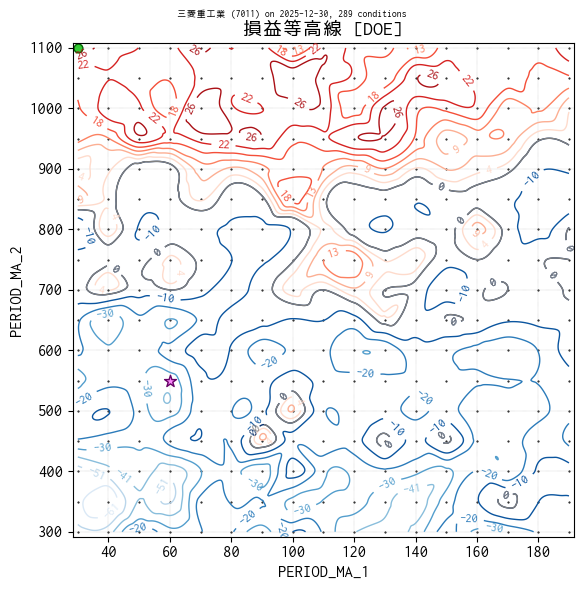

In [13]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# 等高線図
plot_contourmap(ax, Xi, Yi, Zi)

# 本日の条件とベスト条件の点を追加
ax.scatter(df_latest_max[col_x], df_latest_max[col_y], **param_best)
ax.scatter(x_por, y_por, **param_por)
# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"損益等高線 [DOE]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

plt.tight_layout()
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益分布（本日のデータ）

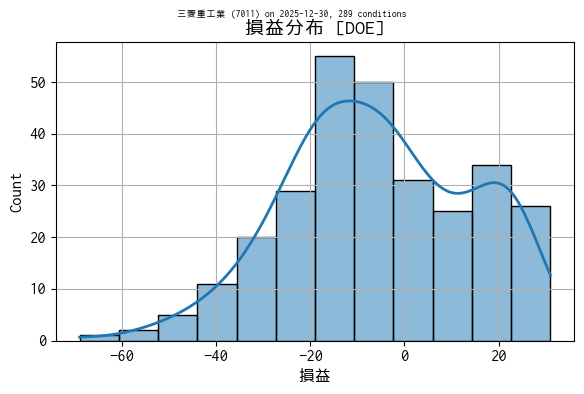

In [14]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df_latest, x="損益", kde=True, line_kws={"linewidth": 2}, ax=ax)
ax.grid()
ax.set_title("損益分布 [DOE]")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_hist_single.png"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.9)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

# ヒストリカル解析

In [15]:
df

,file,code,trade,total,PERIOD_MA_1,PERIOD_MA_2
0,ticks_20250819.xlsx,7011,100,11.0,30,300
1,ticks_20250819.xlsx,7011,100,10.0,40,300
2,ticks_20250819.xlsx,7011,100,6.0,50,300
3,ticks_20250819.xlsx,7011,100,-15.0,60,300
4,ticks_20250819.xlsx,7011,100,25.0,70,300
...,...,...,...,...,...,...
26294,ticks_20251230.xlsx,7011,31,20.0,150,1100
26295,ticks_20251230.xlsx,7011,31,19.0,160,1100
26296,ticks_20251230.xlsx,7011,31,20.0,170,1100
26297,ticks_20251230.xlsx,7011,33,19.0,180,1100


## 最大・最小収益（ヒストリカル）

In [16]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高収益")
print(df[df["total"] == total_max])
print("\n最低収益")
print(df[df["total"] == total_min])

最高収益
                     file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
9638  ticks_20251007.xlsx  7011     45  376.0          190          550

最低収益
                      file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
14481  ticks_20251031.xlsx  7011    100 -250.0          170          350


## サマリ統計の算出（平均）

In [17]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計（平均）")
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_summary.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計（平均）
     PERIOD_MA_1  PERIOD_MA_2      trade     total
0             30          300  99.912088 -0.593407
1             40          300  99.956044 -4.175824
2             50          300  99.483516 -6.043956
3             60          300  98.736264 -9.780220
4             70          300  99.395604 -6.087912
..           ...          ...        ...       ...
284          150         1100  37.417582  0.351648
285          160         1100  36.472527  0.769231
286          170         1100  35.747253  2.109890
287          180         1100  35.065934  1.593407
288          190         1100  34.076923  2.978022

[289 rows x 4 columns]


## 日付 × 条件 で収益を集計（平均）

In [18]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で収益")
print(df_raw)


df_raw: 日付 x 条件で収益
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  11.0  10.0   6.0 -15.0  25.0  12.0  12.0  -8.0  -1.0  -4.0  ...   
2025-08-20   9.0  -2.0   3.0 -18.0   9.0   2.0  23.0  26.0 -16.0  23.0  ...   
2025-08-21 -20.0 -31.0 -40.0 -20.0   0.0 -10.0 -12.0 -21.0   3.0  13.0  ...   
2025-08-22 -52.0 -66.0 -70.0 -28.0 -59.0 -40.0 -51.0 -57.0 -36.0 -33.0  ...   
2025-08-25  -3.0 -20.0  -9.0  -3.0   1.0  -3.0 -17.0  18.0  -8.0  -2.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-24 -20.0 -57.0 -34.0  -7.0  -8.0 -12.0  11.0   2.0   1.0   3.0  ...   
2025-12-25   3.0  -2.0  -5.0   1.0 -20.0 -15.0   0.0  18.0  -8.0 -15.0  ...   
2025-12-26 -30.0 -36.0 -22.0 -18.0 -17.0  -7.0   7.0   0.0  -7.0   0.0  ...   
2025-12-29  42.0 -24.0   5.0  19.0  19.0  11.0  42.0  17.0  33.0  21.0  ...   
2025-12-30 -46.0 -45.0 -15.0 -27.0 -21.0 -19.0 -36.0 -10.0 -22.0 -40.0  ...   

             279   280   281   

### データスコープの文字列

In [19]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days ({name_doe})"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2025-12-30, n = 91 days (doe-9)


## 損益分布（ヒストリカル）

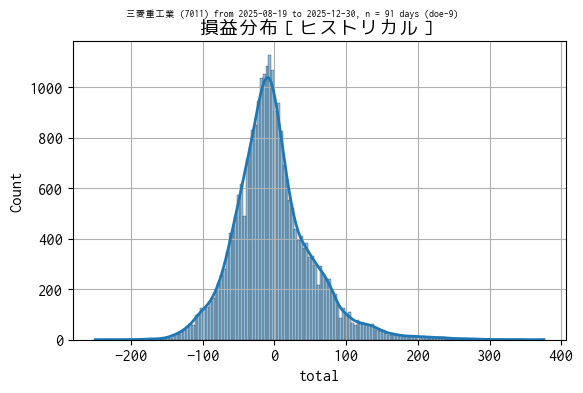

In [20]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df, x="total", kde=True, line_kws={"linewidth": 2}, ax=ax)
ax.grid()
ax.set_title("損益分布［ヒストリカル］")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_hist_profit_all.png"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.9)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 取引回数分布（ヒストリカル）

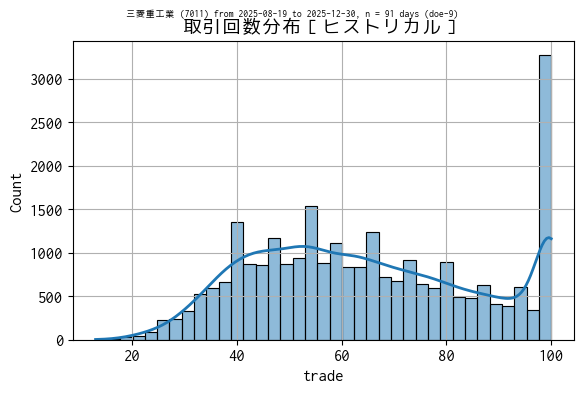

In [21]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df, x="trade", kde=True, line_kws={"linewidth": 2}, ax=ax)
ax.grid()
ax.set_title("取引回数分布［ヒストリカル］")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_hist_trade_all.png"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.9)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 取引回数 vs. 損益 相関

In [22]:
x = df["trade"]
y = df["total"]
# 説明変数に切片追加
x_withconst = sm.add_constant(x)

# OLS モデルを作成し、フィッティング
model = sm.OLS(y, x_withconst)
result = model.fit()

# 結果を表示
print(result.summary())

# 予測値を計算
pred = result.predict()

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2196.
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        07:16:25   Log-Likelihood:            -1.4191e+05
No. Observations:               26299   AIC:                         2.838e+05
Df Residuals:                   26297   BIC:                         2.838e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.0302      1.049     42.938      0.0

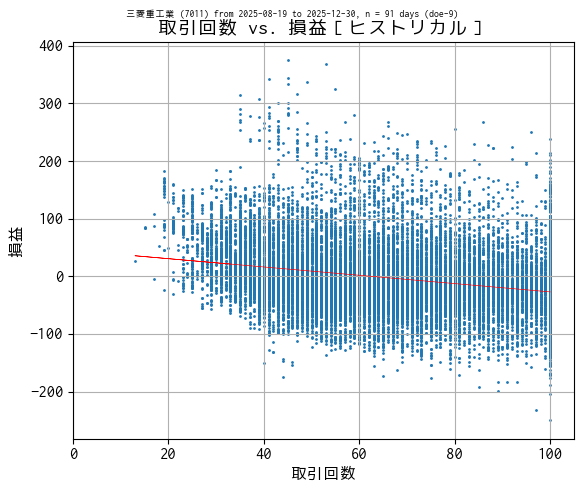

In [23]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(x, y, s=1)
ax.plot(x, pred, c='red',lw=0.5)

ax.grid()
ax.set_xlim(0, 105)
ax.set_xlabel("取引回数")
ax.set_ylabel("損益")
ax.set_title("取引回数 vs. 損益［ヒストリカル］")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_corr_trade_profit_all.png"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.917)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## （ヒストリカル）平均損益の算出

In [24]:
# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)


df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                  0          1          2          3          4          5    \
2025-08-19  11.000000  10.000000   6.000000 -15.000000  25.000000  12.000000   
2025-08-20  10.000000   4.000000   4.500000 -16.500000  17.000000   7.000000   
2025-08-21   0.000000  -7.666667 -10.333333 -17.666667  11.333333   1.333333   
2025-08-22 -13.000000 -22.250000 -25.250000 -20.250000  -6.250000  -9.000000   
2025-08-25 -11.000000 -21.800000 -22.000000 -16.800000  -4.800000  -7.800000   
...               ...        ...        ...        ...        ...        ...   
2025-12-24  -0.264368  -3.137931  -5.896552  -9.942529  -5.919540  -5.793103   
2025-12-25  -0.227273  -3.125000  -5.886364  -9.818182  -6.079545  -5.897727   
2025-12-26  -0.561798  -3.494382  -6.067416  -9.910112  -6.202247  -5.910112   
2025-12-29  -0.088889  -3.722222  -5.944444  -9.588889  -5.922222  -5.722222   
2025-12-30  -0.593407  -4.175824  -6.043956  -9.780220  -6.087912  -5.868132   

      

### 検算

In [25]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング（平均損益）

In [26]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数      平均損益  2025-12-30
117          180          600  52.571429  8.120879       -20.0
99           170          550  58.681319  7.945055       -20.0
16           190          300  97.780220  6.065934       -13.0
118          190          600  53.318681  5.769231        -4.0
100          180          550  57.527473  5.065934       -20.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数       平均損益  2025-12-30
252          170         1000  37.978022  -0.021978        11.0
79           140          500  65.472527  -0.021978       -23.0
87            50          550  86.637363  -0.032967       -28.0
77           120          500  68.758242  -0.087912       -13.0
145          120          700  55.197802  -0.109890         8.0
..           ...          ...        ...        ...         ...
204           30          900  84.384615  -9.824176         2.0
37            60          400  95.340659  -9.923077       -46.0
38 

## 実験条件毎の平均損益トレンド

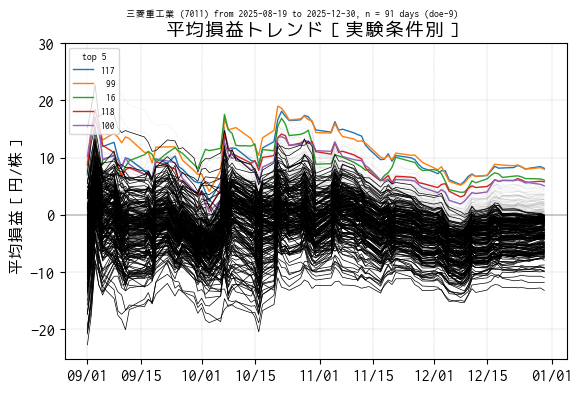

In [27]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均損益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title("平均損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## ヒストリカル・データで等高線図 (Contour Map)

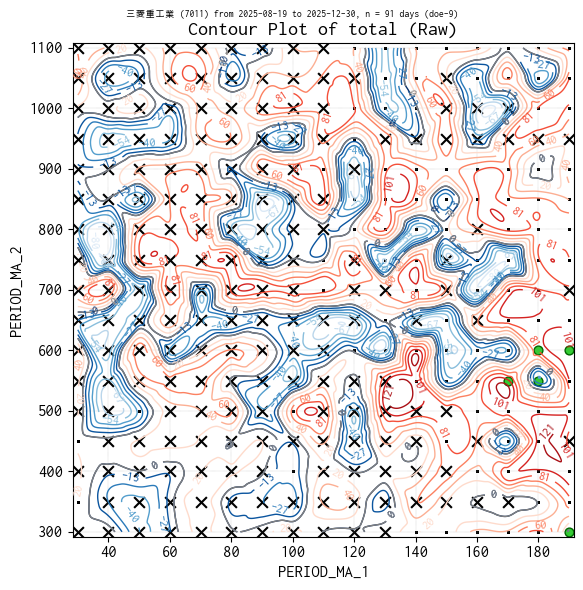

In [28]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# 等高線図
plot_contourmap(ax, Xi, Yi, Zi)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## （ヒストリカル）メジアン損益の算出

In [29]:
df_median = df_raw.copy()

In [30]:
# メディアン損益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメジアン損益を算出")
print(df_median)

# 最終日の平均収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメジアン損益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメジアン損益を算出
             0     1     2     3     4     5     6     7    8     9    ...  \
2025-08-19  11.0  10.0   6.0 -15.0  25.0  12.0  12.0  -8.0 -1.0  -4.0  ...   
2025-08-20  10.0   4.0   4.5 -16.5  17.0   7.0  17.5   9.0 -8.5   9.5  ...   
2025-08-21   9.0  -2.0   3.0 -18.0   9.0   2.0  12.0  -8.0 -1.0  13.0  ...   
2025-08-22  -5.5 -16.5 -18.5 -19.0   4.5  -4.0   0.0 -14.5 -8.5   4.5  ...   
2025-08-25  -3.0 -20.0  -9.0 -18.0   1.0  -3.0 -12.0  -8.0 -8.0  -2.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...  ...   ...  ...   
2025-12-24  -7.0  -4.0 -14.0 -18.0  -6.0  -8.0 -10.0  -8.0 -6.0  -9.0  ...   
2025-12-25  -7.0  -3.5 -13.0 -18.0  -6.5  -9.0  -9.5  -7.0 -6.0 -11.0  ...   
2025-12-26  -7.0  -4.0 -14.0 -18.0  -7.0  -8.0  -9.0  -6.0 -6.0  -9.0  ...   
2025-12-29  -7.0  -4.5 -13.0 -18.0  -6.5  -7.5  -8.5  -6.0 -6.0  -9.0  ...   
2025-12-30  -7.0  -5.0 -14.0 -18.0  -7.0  -8.0  -9.0  -6.0 -6.0  -9.0  ...   

             279   280   2

## サマリ統計（メジアン）

In [31]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メジアン）")
print(df_summary_2)

サマリ統計（メジアン）
     PERIOD_MA_1  PERIOD_MA_2  trade  total
0             30          300  100.0   -7.0
1             40          300  100.0   -5.0
2             50          300  100.0  -14.0
3             60          300  100.0  -18.0
4             70          300  100.0   -7.0
..           ...          ...    ...    ...
284          150         1100   38.0   -5.0
285          160         1100   37.0   -1.0
286          170         1100   36.0   -3.0
287          180         1100   35.0   -2.0
288          190         1100   35.0   -1.0

[289 rows x 4 columns]


### 検算

In [32]:
"""
サマリ統計 (df_summary_2) のメジアン値と、算出したメジアン収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [33]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best_median.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)


# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2   取引回数  メジアン損益  2025-12-30
15           180          300   92.0     8.0       -19.0
283          140         1100   39.0     2.0        12.0
16           190          300  100.0     2.0       -13.0
33           190          350   87.0     1.0       -12.0
99           170          550   57.0     1.0       -20.0
263          110         1050   43.0     1.0        25.0
197          130          850   46.0     0.0        -4.0
253          180         1000   37.0     0.0        14.0
245          100         1000   45.0     0.0        25.0
168          180          750   43.0     0.0        -1.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2   取引回数  メジアン損益  2025-12-30
50           190          400   75.0    -1.0        -6.0
75           100          500   66.0    -1.0         9.0
228          100          950   45.0    -1.0        19.0
180          130          800   50.0    -1.0       -11.0
285          160         1100   37.0    -1.0 

## 実験条件毎の収益トレンド（メジアン）

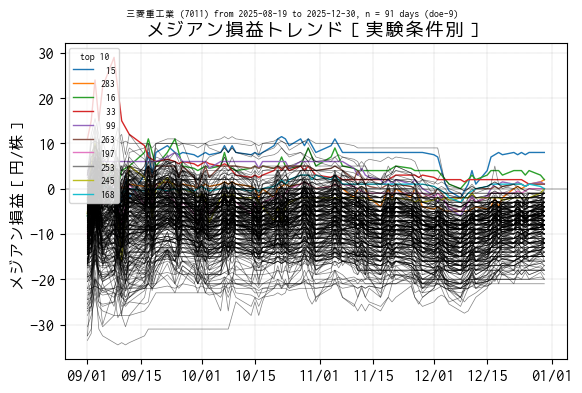

In [34]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキング だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン損益［円/株］")
ax.set_title("メジアン損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_median_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()